# Multivariate LSTM Models

## Multiple Input Series

In [29]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import tensorflow
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Bidirectional
from tensorflow import keras
from keras.optimizers import Adam
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [30]:
crypto_prices = read_csv('crypto_final.csv', header=0, index_col=0, squeeze=True)
crypto_prices["Date"] = crypto_prices['Date'].astype('datetime64[ns]')
sentiment = read_csv('BERT-VADERaggregatedcontinuous.csv', header=0, index_col=0, squeeze=True)
def sentconvert(x):
    if x < 0:
        return -1
    elif x == 0:
        return 0
    else:
        return 1
sentiment["Pred_label_cat"]=sentiment["Pred_label"].apply(lambda x: sentconvert(x))
sentiment['Date']=sentiment.index.copy()
sentiment["Date"] = sentiment['Date'].astype('datetime64[ns]')
sentiment.head()

,Pred_label,retweets_count,likes_count,Pred_label_cat,Date
dt_bst_date,,,,,
2021-06-30,0.400000,2495.200000,16504.500000,1,2021-06-30
2021-06-29,0.166667,1153.250000,10513.583333,1,2021-06-29
2021-06-28,0.750000,5541.500000,117710.000000,1,2021-06-28
2021-06-27,0.500000,13021.500000,165885.500000,1,2021-06-27
2021-06-26,0.666667,5505.333333,81219.666667,1,2021-06-26


In [31]:
#series2["Date"] = series2['dt_bst_date'].astype('datetime64[ns]')
crypto_sentiment = crypto_prices.merge(sentiment, on = 'Date', indicator=True, how='left')
crypto_sentiment['Pred_label'].fillna(0, inplace =True) 
crypto_sentiment['Pred_label_cat'].fillna(0, inplace =True) 
crypto_sentiment['retweets_count'].fillna(0, inplace =True) 
crypto_sentiment['likes_count'].fillna(0, inplace =True) 
btc_list = crypto_sentiment['btc_cp'].to_list()
sent_list = [1]
for i in range(1,crypto_sentiment.shape[0]):
    if btc_list[i]>btc_list[i-1]:
        sent_list.append(1)
    elif btc_list[i]<btc_list[i-1]:
        sent_list.append(0)
    else: sent_list.append(-1)

crypto_sentiment.head(10)

,Date,btc_cp,doge_cp,eth_cp,Pred_label,retweets_count,likes_count,Pred_label_cat,_merge
0,2018-01-01,13657.20020,0.008909,772.640991,0.00,0.0,0.0,0.0,left_only
1,2018-01-02,14982.09961,0.009145,884.443970,0.00,0.0,0.0,0.0,left_only
2,2018-01-03,15201.00000,0.009320,962.719971,0.00,4706.5,35113.5,0.0,both
3,2018-01-04,15599.20020,0.009644,980.921997,0.00,0.0,0.0,0.0,left_only
4,2018-01-05,17429.50000,0.012167,997.719971,0.00,9184.0,56223.5,0.0,both
5,2018-01-06,17527.00000,0.014863,1041.680054,0.00,0.0,0.0,0.0,left_only
6,2018-01-07,16477.59961,0.017088,1153.170044,-0.25,3946.5,45543.5,-1.0,both
7,2018-01-08,15170.09961,0.015045,1148.530029,1.00,2988.0,19952.0,1.0,both
8,2018-01-09,14595.40039,0.013420,1299.739990,0.50,110.0,4581.0,1.0,both
9,2018-01-10,14973.29981,0.013102,1255.819946,0.00,0.0,0.0,0.0,left_only


In [32]:
crypto_sentiment.shape

(1277, 9)

In [33]:
y_min = crypto_sentiment.btc_cp.min()
y_max = crypto_sentiment.btc_cp.max()

In [34]:
crypto_sentiment.iloc[:,1]

0       13657.20020
1       14982.09961
2       15201.00000
3       15599.20020
4       17429.50000
           ...     
1272    32186.27734
1273    34649.64453
1274    34434.33594
1275    35867.77734
1276    35040.83594
Name: btc_cp, Length: 1277, dtype: float64

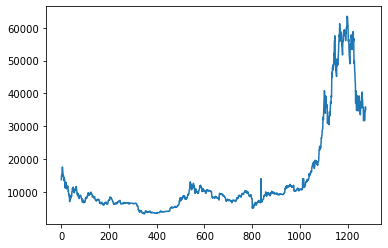

In [35]:
plt.plot(crypto_sentiment.iloc[:,1])
plt.show()


In [36]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [37]:


def reframedData(data,backwarddays,forwarddays,n_features,range1=0,range2=1):
    values = data.astype('float32')
# normalize features
    scaler = MinMaxScaler(feature_range=(range1, range2))
    scaled = scaler.fit_transform(values)
    print(scaled)
    reframed = series_to_supervised(scaled,backwarddays,forwarddays)
    removedColumns = []
    for i in range(1,forwarddays*n_features):
        if(i%n_features!=0):
            removedColumns.append(-i);
    print(removedColumns)
    reframed.drop(reframed.columns[removedColumns], axis=1, inplace=True);
    return reframed,scaler;

2018/1/1 - 2021/6/30 1280 rows
training 900
validation: 200
test: 50

In [38]:
def data_split_and_reshape(data,n_val_days,n_test_days):
    values = data.values
    train = values[:-n_test_days-n_val_days, :]
    val = values[-n_test_days-n_val_days:-n_test_days, :]
    test = values[-n_test_days:, :]
    # split into input and outputs
    train_X, train_y = train[:,:-forwarddays], train[:,-forwarddays:]
    val_X, val_y = val[:, :-forwarddays], val[:, -forwarddays:]
    test_X, test_y = test[:, :-forwarddays], test[:, -forwarddays:]
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], backwarddays, n_features))
    val_X = val_X.reshape((val_X.shape[0], backwarddays, n_features))
    test_X = test_X.reshape((test_X.shape[0], backwarddays, n_features))
    return train_X, train_y, val_X, val_y, test_X, test_y;
    

# Stacked Gated Recurrent Units
### GRU Model 1 considering features: Bitcoin price and Elon Musk's Tweet sentiment score

In [39]:
backwarddays =5
forwarddays = 1
n_features = 2
btc_sent = crypto_sentiment.iloc[1:,[1,7]].values
#values1 = series3.iloc[1:,[1,2,3,5,9,10]].values
reframed,scaler = reframedData(btc_sent,backwarddays,forwarddays,n_features,-1,1)
#reframed1,scaler1 = reframedData(values,backwarddays,forwarddays,n_features,-1,1)
print(reframed)
n_val_days=250
n_test_days=15
train_X, train_y, val_X, val_y, test_X, test_y=data_split_and_reshape(reframed,n_val_days,n_test_days)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

[[-0.61022127  0.        ]
 [-0.6029569   0.        ]
 [-0.5897423   0.        ]
 ...
 [ 0.03531718  1.        ]
 [ 0.08288717  1.        ]
 [ 0.05544448  1.        ]]
[-1]
      var1(t-5)  var2(t-5)  var1(t-4)  var2(t-4)  var1(t-3)  var2(t-3)  \
5     -0.610221        0.0  -0.602957        0.0  -0.589742        0.0   
6     -0.602957        0.0  -0.589742        0.0  -0.529002        0.0   
7     -0.589742        0.0  -0.529002        0.0  -0.525767        0.0   
8     -0.529002        0.0  -0.525767        0.0  -0.560592       -1.0   
9     -0.525767        0.0  -0.560592       -1.0  -0.603982        1.0   
...         ...        ...        ...        ...        ...        ...   
1271  -0.056197        1.0  -0.028687        1.0   0.011712        0.0   
1272  -0.028687        1.0   0.011712        0.0   0.042887        1.0   
1273   0.011712        0.0   0.042887        1.0  -0.057489        1.0   
1274   0.042887        1.0  -0.057489        1.0  -0.039286        1.0   
1275  -0.0574

In [40]:
seed(11111)
tensorflow.random.set_seed(11111)
model_gru = Sequential()
model_gru.add(GRU(128, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=64, return_sequences=True))
model_gru.add(GRU(units=32))
model_gru.add(Dense(1))
model_gru.compile(loss='mse', optimizer='adam')

In [41]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(train_X, train_y, epochs = 1000,  
                        validation_data=(val_X, val_y),
                        batch_size = 64, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)
model_gru.summary()

Epoch 1/1000
16/16 [==============================] - 4s 45ms/step - loss: 0.2561 - val_loss: 0.2347
Epoch 2/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0407 - val_loss: 0.2090
Epoch 3/1000
16/16 [==============================] - 0s 16ms/step - loss: 0.0037 - val_loss: 0.1411
Epoch 4/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.1143
Epoch 5/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.1027
Epoch 6/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0034 - val_loss: 0.0970
Epoch 7/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0034 - val_loss: 0.0912
Epoch 8/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0840
Epoch 9/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0771
Epoch 10/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss

Epoch 82/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0143
Epoch 83/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0142
Epoch 84/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0141
Epoch 85/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0140
Epoch 86/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0140
Epoch 87/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0139
Epoch 88/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0138
Epoch 89/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0137
Epoch 90/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0136
Epoch 91/1000
16/16 [==============================] - 0s 10ms/step - loss: 0.0019 - 

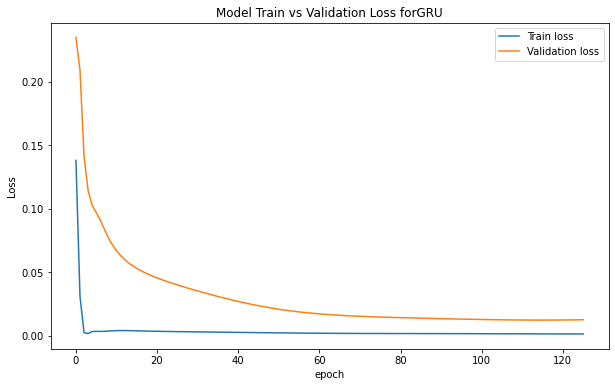

In [42]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss(history_gru, 'GRU')


Test RMSE: 2093.693


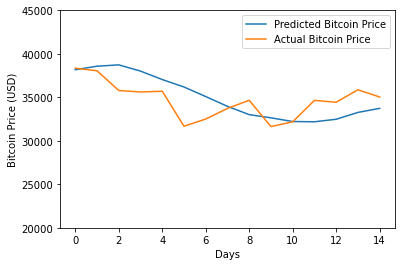

,Actual,Predicted
0,38347.062500,38175.261719
1,38053.503906,38579.988281
2,35787.246094,38733.816406
3,35615.871094,38016.800781
4,35698.296875,37045.042969
5,31676.693359,36189.476562
6,32505.660156,35088.238281
7,33723.027344,33963.535156
8,34662.437500,33010.925781
9,31637.779297,32644.365234


In [43]:
# make a prediction
yhat = model_gru.predict(test_X)
test_X_Re = test_X.reshape((test_X.shape[0], backwarddays*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
inv_y = concatenate((test_y[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

# calculate RMSE
#print(concatenate((inv_yhat[:,:1], inv_y[:,:1]), axis=1))
rmse = sqrt(mean_squared_error(inv_yhat[:,0], inv_y[:,0]))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat[:,0], label='Predicted Bitcoin Price')
pyplot.plot(inv_y[:,0], label='Actual Bitcoin Price')
pyplot.xlabel("Days")
pyplot.ylabel("Bitcoin Price (USD)")
x1,x2,y1,y2 = pyplot.axis()  
pyplot.axis((x1,x2,20000,45000))
pyplot.legend()
pyplot.show()
bitcoin_price = pd.DataFrame(columns = {'Predicted', 'Actual'})
bitcoin_price['Predicted'] = inv_yhat[:,0]
bitcoin_price['Actual'] = inv_y[:,0]
bitcoin_price

In [44]:
btc_sent_pred_x=inv_yhat[:,:1]

### GRU Model 2 considering feature: Bitcoin price alone

In [45]:
backwarddays =5
forwarddays = 1
n_features = 1
btc = crypto_sentiment.iloc[1:,[1]].values
#values1 = series3.iloc[1:,[1,2,3,5,9,10]].values
reframed,scaler = reframedData(btc,backwarddays,forwarddays,n_features,-1,1)
#reframed1,scaler1 = reframedData(values,backwarddays,forwarddays,n_features,-1,1)
print(reframed)
n_val_days=250
n_test_days=15
train_X, train_y, val_X, val_y, test_X, test_y=data_split_and_reshape(reframed,n_val_days,n_test_days)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

[[-0.61022127]
 [-0.6029569 ]
 [-0.5897423 ]
 ...
 [ 0.03531718]
 [ 0.08288717]
 [ 0.05544448]]
[]
      var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)
5     -0.610221  -0.602957  -0.589742  -0.529002  -0.525767 -0.560592
6     -0.602957  -0.589742  -0.529002  -0.525767  -0.560592 -0.603982
7     -0.589742  -0.529002  -0.525767  -0.560592  -0.603982 -0.623054
8     -0.529002  -0.525767  -0.560592  -0.603982  -0.623054 -0.610513
9     -0.525767  -0.560592  -0.603982  -0.623054  -0.610513 -0.662532
...         ...        ...        ...        ...        ...       ...
1271  -0.056197  -0.028687   0.011712   0.042887  -0.057489 -0.039286
1272  -0.028687   0.011712   0.042887  -0.057489  -0.039286  0.042462
1273   0.011712   0.042887  -0.057489  -0.039286   0.042462  0.035317
1274   0.042887  -0.057489  -0.039286   0.042462   0.035317  0.082887
1275  -0.057489  -0.039286   0.042462   0.035317   0.082887  0.055444

[1271 rows x 6 columns]
(1006, 5, 1) (1006, 1) (250, 5, 1) (

In [46]:
seed(11111)
tensorflow.random.set_seed(11111)
model_gru1 = Sequential()
model_gru1.add(GRU(128, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru1.add(GRU(units=64, return_sequences=True))
model_gru1.add(GRU(units=32))
model_gru1.add(Dense(1))
model_gru1.compile(loss='mse', optimizer='adam')
history_gru1 = fit_model(model_gru1)
model_gru1.summary()

Epoch 1/1000
16/16 [==============================] - 4s 49ms/step - loss: 0.2914 - val_loss: 0.1058
Epoch 2/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.1159
Epoch 3/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.1103
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.1083
Epoch 5/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.1037
Epoch 6/1000
16/16 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0976
Epoch 7/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0915
Epoch 8/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0856
Epoch 9/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0798
Epoch 10/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.0029 - val_loss: 0.0

Epoch 82/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0225
Epoch 83/1000
16/16 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0226
Epoch 84/1000
16/16 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0226
Epoch 85/1000
16/16 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0227
Epoch 86/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0227
Epoch 87/1000
16/16 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0228
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_12 (ModuleWra (None, 5, 128)            50304     
_________________________________________________________________
module_wrapper_13 (ModuleWra (None, 5, 64)             37248     
_____________________________________

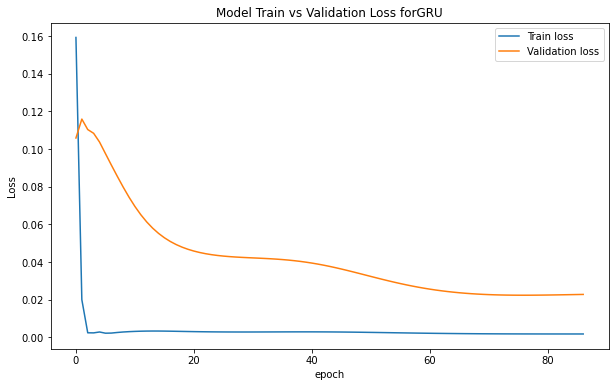

In [47]:
plot_loss(history_gru1, 'GRU')

Test RMSE: 2561.746


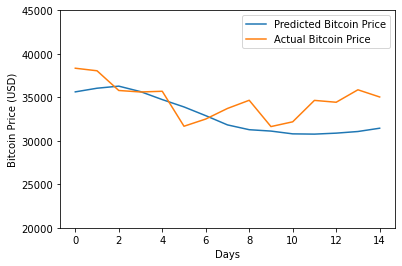

,Actual,Predicted
0,38347.062500,35628.519531
1,38053.503906,36047.761719
2,35787.246094,36286.214844
3,35615.871094,35656.917969
4,35698.296875,34741.699219
5,31676.693359,33896.203125
6,32505.660156,32892.222656
7,33723.027344,31831.185547
8,34662.437500,31279.105469
9,31637.779297,31120.265625


In [48]:
# make a prediction
yhat = model_gru1.predict(test_X)
test_X_Re = test_X.reshape((test_X.shape[0], backwarddays*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
inv_y = concatenate((test_y[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
# calculate RMSE
#print(concatenate((inv_yhat[:,:1], inv_y[:,:1]), axis=1))
rmse = sqrt(mean_squared_error(inv_yhat[:,0], inv_y[:,0]))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat[:,0], label='Predicted Bitcoin Price')
pyplot.plot(inv_y[:,0], label='Actual Bitcoin Price')
pyplot.xlabel("Days")
pyplot.ylabel("Bitcoin Price (USD)")
x1,x2,y1,y2 = pyplot.axis()  
pyplot.axis((x1,x2,20000,45000))
pyplot.legend()
pyplot.show()
bitcoin_price = pd.DataFrame(columns = {'Predicted', 'Actual'})
bitcoin_price['Predicted'] = inv_yhat[:,0]
bitcoin_price['Actual'] = inv_y[:,0]
bitcoin_price

In [49]:
btc_sent_pred_y=inv_yhat[:,:1]

#### T-Test to check if difference between the RMSE for GRU model with features Bitcoin Price and Elon Musk's tweet sentiment score  and RMSE for GRU model with only Bitcoin Price as the feature is statistically significant

In [50]:
#t-test for full dataset
ttest,pval = ttest_ind(btc_sent_pred_x,btc_sent_pred_y)
print("p-value",pval)

p-value [0.02302318]


Since the p-value for the above t-test at 95% confidence is lower than the significance level of 5%, we can say that the difference in RMSE for the Bitcoin price prediction models with and without Elon Musk's tweet sentiment is statistically significant at 95% confidence level.

## Sliced dataset Models

The bitcoin sentiment dataset used earlier contained a lot of volatility towards the right end of the plot, so we tried to slice the relatively stable part of the curve to check if the RMSE is lower. Looking at data uptil 04 October 2020:

In [51]:
crypto_sentiment_sliced = crypto_sentiment[crypto_sentiment.Date < "2020-10-5"]
crypto_sentiment_sliced.head(10)

,Date,btc_cp,doge_cp,eth_cp,Pred_label,retweets_count,likes_count,Pred_label_cat,_merge
0,2018-01-01,13657.20020,0.008909,772.640991,0.00,0.0,0.0,0.0,left_only
1,2018-01-02,14982.09961,0.009145,884.443970,0.00,0.0,0.0,0.0,left_only
2,2018-01-03,15201.00000,0.009320,962.719971,0.00,4706.5,35113.5,0.0,both
3,2018-01-04,15599.20020,0.009644,980.921997,0.00,0.0,0.0,0.0,left_only
4,2018-01-05,17429.50000,0.012167,997.719971,0.00,9184.0,56223.5,0.0,both
5,2018-01-06,17527.00000,0.014863,1041.680054,0.00,0.0,0.0,0.0,left_only
6,2018-01-07,16477.59961,0.017088,1153.170044,-0.25,3946.5,45543.5,-1.0,both
7,2018-01-08,15170.09961,0.015045,1148.530029,1.00,2988.0,19952.0,1.0,both
8,2018-01-09,14595.40039,0.013420,1299.739990,0.50,110.0,4581.0,1.0,both
9,2018-01-10,14973.29981,0.013102,1255.819946,0.00,0.0,0.0,0.0,left_only


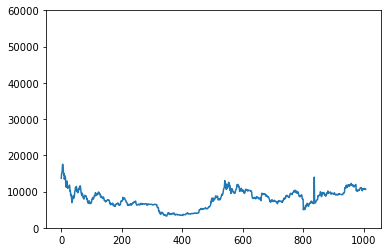

In [52]:
plt.plot(crypto_sentiment_sliced.iloc[:,1])
x1,x2,y1,y2 = pyplot.axis()  
pyplot.axis((x1,x2,0,60000))
plt.show()

In [53]:
backwarddays = 7
forwarddays = 1
n_features = 2
btc_sent1 = crypto_sentiment_sliced.iloc[1:,[1,7]].values
#values1 = series3.iloc[1:,[1,2,3,5,9,10]].values
reframed,scaler = reframedData(btc_sent1,backwarddays,forwarddays,n_features,-1,1)
#reframed1,scaler1 = reframedData(values,backwarddays,forwarddays,n_features,-1,1)
print(reframed)
n_val_days=100
n_test_days=30
train_X, train_y, val_X, val_y, test_X, test_y=data_split_and_reshape(reframed,n_val_days,n_test_days)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

[[0.6438267  0.        ]
 [0.67446303 0.        ]
 [0.7301934  0.        ]
 ...
 [0.02845061 1.        ]
 [0.02569759 1.        ]
 [0.04234326 1.        ]]
[-1]
      var1(t-7)  var2(t-7)  var1(t-6)  var2(t-6)  var1(t-5)  var2(t-5)  \
7      0.643827        0.0   0.674463        0.0   0.730193        0.0   
8      0.674463        0.0   0.730193        0.0   0.986354        0.0   
9      0.730193        0.0   0.986354        0.0   1.000000        0.0   
10     0.986354        0.0   1.000000        0.0   0.853131       -1.0   
11     1.000000        0.0   0.853131       -1.0   0.670138        1.0   
...         ...        ...        ...        ...        ...        ...   
1002  -0.021835        1.0   0.050897        1.0   0.044843        1.0   
1003   0.050897        1.0   0.044843        1.0   0.052141        1.0   
1004   0.044843        1.0   0.052141        1.0   0.054939        1.0   
1005   0.052141        1.0   0.054939        1.0   0.047507        1.0   
1006   0.054939        1.

### GRU Model 3 considering features: Bitcoin price and Elon Musk's Tweet sentiment score

In [54]:
seed(11111)
tensorflow.random.set_seed(11111)
model_gru2 = Sequential()
model_gru2.add(GRU(128, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru2.add(GRU(units=64, return_sequences=True))
#model_gru.add(GRU(units=64, return_sequences=True))
#model_gru.add(GRU(units=64, return_sequences=True))
model_gru2.add(GRU(units=32))
model_gru2.add(Dense(1))
model_gru2.compile(loss='mse', optimizer='adam')
history_gru2 = fit_model(model_gru2)
model_gru2.summary()

Epoch 1/1000
14/14 [==============================] - 4s 58ms/step - loss: 0.0740 - val_loss: 0.0197
Epoch 2/1000
14/14 [==============================] - 0s 11ms/step - loss: 0.0831 - val_loss: 0.0290
Epoch 3/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0148 - val_loss: 0.0032
Epoch 4/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.0156 - val_loss: 0.0063
Epoch 5/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0125 - val_loss: 0.0027
Epoch 6/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0104 - val_loss: 0.0053
Epoch 7/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0094 - val_loss: 0.0030
Epoch 8/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 9/1000
14/14 [==============================] - 0s 12ms/step - loss: 0.0093 - val_loss: 0.0034
Epoch 10/1000
14/14 [==============================] - 0s 14ms/step - loss: 0.0088 - val_loss

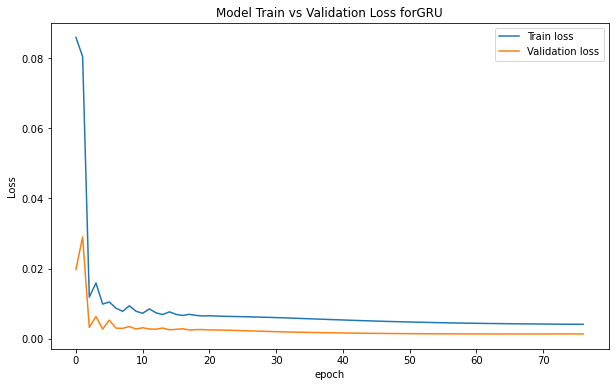

In [55]:
plot_loss(history_gru2, 'GRU')

Test RMSE: 198.103


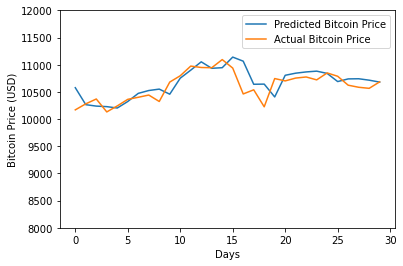

,Actual,Predicted
0,10169.567383,10577.313477
1,10280.351562,10264.897461
2,10369.563477,10238.744141
3,10131.516602,10228.791016
4,10242.347656,10203.445312
5,10363.138672,10323.419922
6,10400.915039,10472.916016
7,10442.170898,10525.429688
8,10323.755859,10551.279297
9,10680.837891,10457.889648


In [56]:
# make a prediction
yhat = model_gru2.predict(test_X)
test_X_Re = test_X.reshape((test_X.shape[0], backwarddays*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
inv_y = concatenate((test_y[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

# calculate RMSE
#print(concatenate((inv_yhat[:,:1], inv_y[:,:1]), axis=1))
rmse = sqrt(mean_squared_error(inv_yhat[:,0], inv_y[:,0]))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat[:,0], label='Predicted Bitcoin Price')
pyplot.plot(inv_y[:,0], label='Actual Bitcoin Price')
pyplot.xlabel("Days")
pyplot.ylabel("Bitcoin Price (USD)")
x1,x2,y1,y2 = pyplot.axis()  
pyplot.axis((x1,x2,8000,12000))
pyplot.legend()
pyplot.show()
bitcoin_price = pd.DataFrame(columns = {'Predicted', 'Actual'})
bitcoin_price['Predicted'] = inv_yhat[:,0]
bitcoin_price['Actual'] = inv_y[:,0]
bitcoin_price

Clearly, the RMSE is much lower for the sliced dataset when compared to dataset with the highly volatile bitcoin prices.

In [57]:
btc_sent_pred_x1=inv_yhat[:,:1]

### GRU Model 4 considering feature: Bitcoin price alone

In [58]:
backwarddays =7
forwarddays = 1
n_features = 1
btc1 = crypto_sentiment_sliced.iloc[1:,[1]].values
#values1 = series3.iloc[1:,[1,2,3,5,9,10]].values
reframed,scaler = reframedData(btc1,backwarddays,forwarddays,n_features,-1,1)
#reframed1,scaler1 = reframedData(values,backwarddays,forwarddays,n_features,-1,1)
print(reframed)
n_val_days=100
n_test_days=30
train_X, train_y, val_X, val_y, test_X, test_y=data_split_and_reshape(reframed,n_val_days,n_test_days)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

[[0.6438267 ]
 [0.67446303]
 [0.7301934 ]
 ...
 [0.02845061]
 [0.02569759]
 [0.04234326]]
[]
      var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  \
7      0.643827   0.674463   0.730193   0.986354   1.000000   0.853131   
8      0.674463   0.730193   0.986354   1.000000   0.853131   0.670138   
9      0.730193   0.986354   1.000000   0.853131   0.670138   0.589706   
10     0.986354   1.000000   0.853131   0.670138   0.589706   0.642595   
11     1.000000   0.853131   0.670138   0.589706   0.642595   0.423215   
...         ...        ...        ...        ...        ...        ...   
1002  -0.021835   0.050897   0.044843   0.052141   0.054939   0.047507   
1003   0.050897   0.044843   0.052141   0.054939   0.047507   0.065352   
1004   0.044843   0.052141   0.054939   0.047507   0.065352   0.056785   
1005   0.052141   0.054939   0.047507   0.065352   0.056785   0.033792   
1006   0.054939   0.047507   0.065352   0.056785   0.033792   0.028451   

      var1(t-1)   

In [59]:
seed(11111)
tensorflow.random.set_seed(11111)
model_gru3 = Sequential()
model_gru3.add(GRU(128, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru3.add(GRU(units=64, return_sequences=True))
model_gru3.add(GRU(units=32))
model_gru3.add(Dense(1))
model_gru3.compile(loss='mse', optimizer='adam')
history_gru3 = fit_model(model_gru3)
model_gru3.summary()

Epoch 1/1000
14/14 [==============================] - 4s 62ms/step - loss: 0.0729 - val_loss: 0.0133
Epoch 2/1000
14/14 [==============================] - 0s 12ms/step - loss: 0.0222 - val_loss: 0.0061
Epoch 3/1000
14/14 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0034
Epoch 4/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0157 - val_loss: 0.0088
Epoch 5/1000
14/14 [==============================] - 0s 11ms/step - loss: 0.0115 - val_loss: 0.0027
Epoch 6/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0101 - val_loss: 0.0046
Epoch 7/1000
14/14 [==============================] - 0s 11ms/step - loss: 0.0090 - val_loss: 0.0028
Epoch 8/1000
14/14 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 9/1000
14/14 [==============================] - 0s 13ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 10/1000
14/14 [==============================] - 0s 14ms/step - loss: 0.0081 - val_lo

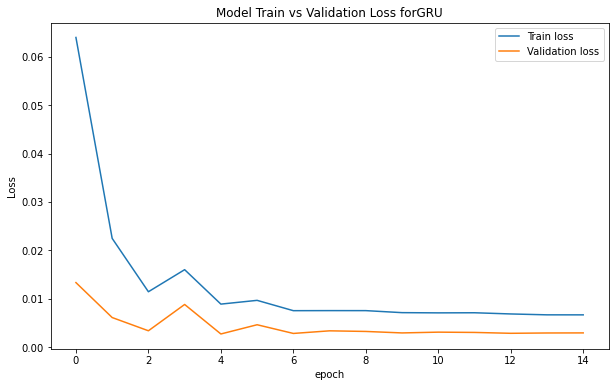

In [60]:
plot_loss(history_gru3, 'GRU')

Test RMSE: 321.442


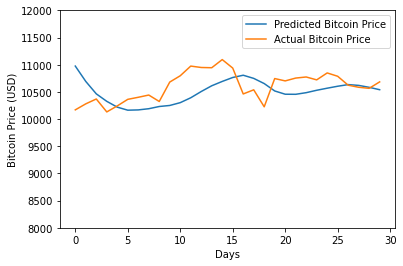

,Actual,Predicted
0,10169.567383,10975.129883
1,10280.351562,10692.234375
2,10369.563477,10464.208008
3,10131.516602,10326.169922
4,10242.347656,10219.520508
5,10363.138672,10163.609375
6,10400.915039,10168.745117
7,10442.170898,10190.632812
8,10323.755859,10231.435547
9,10680.837891,10250.437500


In [61]:
# make a prediction
yhat = model_gru3.predict(test_X)
test_X_Re = test_X.reshape((test_X.shape[0], backwarddays*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
inv_y = concatenate((test_y[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

# calculate RMSE
#print(concatenate((inv_yhat[:,:1], inv_y[:,:1]), axis=1))
rmse = sqrt(mean_squared_error(inv_yhat[:,0], inv_y[:,0]))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat[:,0], label='Predicted Bitcoin Price')
pyplot.plot(inv_y[:,0], label='Actual Bitcoin Price')
pyplot.xlabel("Days")
pyplot.ylabel("Bitcoin Price (USD)")
x1,x2,y1,y2 = pyplot.axis()  
pyplot.axis((x1,x2,8000,12000))
pyplot.legend()
pyplot.show()
bitcoin_price = pd.DataFrame(columns = {'Predicted', 'Actual'})
bitcoin_price['Predicted'] = inv_yhat[:,0]
bitcoin_price['Actual'] = inv_y[:,0]
bitcoin_price

In [62]:
btc_sent_pred_y1=inv_yhat[:,:1]

#### T-Test to check if difference between the RMSE for GRU model with features Bitcoin Price and Elon Musk's tweet sentiment score  and RMSE for GRU model with only Bitcoin Price as the feature is statistically significant

In [63]:
#t-test for sliced dataset
ttest,pval = ttest_ind(btc_sent_pred_x1,btc_sent_pred_y1)
print("p-value",pval)

p-value [0.00850409]


Since the p-value for the above t-test at 95% confidence is lower than the significance level of 5%, we can say that the difference in RMSE for the Bitcoin price prediction models with and without Elon Musk's tweet sentiment is statistically significant at 95% confidence level.

### GRU Model 5 considering features: Bitcoin price, Elon Musk's tweet sentiment, Retweet count, Likes count, Ethereum prices and Doge Coin prices

In [64]:
backwarddays =5
forwarddays = 1
n_features = 6
values = crypto_sentiment.iloc[1:,[1,2,3,5,6,7]].values
#values1 = series3.iloc[1:,[1,2,3,5,9,10]].values
reframed,scaler = reframedData(values,backwarddays,forwarddays,n_features,-1,1)
#reframed1,scaler1 = reframedData(values,backwarddays,forwarddays,n_features,-1,1)
print(reframed)
n_val_days=200
n_test_days=15
train_X, train_y, val_X, val_y, test_X, test_y=data_split_and_reshape(reframed,n_val_days,n_test_days)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

[[-0.61022127 -0.9777297  -0.60819846 -1.         -1.          0.        ]
 [-0.6029569  -0.97721744 -0.56986916 -0.9687681  -0.955927    0.        ]
 [-0.5897423  -0.976269   -0.5609562  -1.         -1.          0.        ]
 ...
 [ 0.03531718 -0.25261986 -0.02293968 -0.96322715 -0.85225534  1.        ]
 [ 0.08288717 -0.23531407  0.01677787 -0.9923471  -0.98680377  1.        ]
 [ 0.05544448 -0.26035362  0.072492   -0.9834421  -0.9792842   1.        ]]
[-1, -2, -3, -4, -5]
      var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5     -0.610221  -0.977730  -0.608198  -1.000000  -1.000000        0.0   
6     -0.602957  -0.977217  -0.569869  -0.968768  -0.955927        0.0   
7     -0.589742  -0.976269  -0.560956  -1.000000  -1.000000        0.0   
8     -0.529002  -0.968884  -0.552731  -0.939056  -0.929431        0.0   
9     -0.525767  -0.960992  -0.531205  -1.000000  -1.000000        0.0   
...         ...        ...        ...        ...        ...        ...   
1271 

In [65]:
seed(11111)
tensorflow.random.set_seed(11111)
model_gru4 = Sequential()
model_gru4.add(GRU(128, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru4.add(GRU(units=64, return_sequences=True))
#model_gru.add(GRU(units=64, return_sequences=True))
#model_gru.add(GRU(units=64, return_sequences=True))
model_gru4.add(GRU(units=32))
model_gru4.add(Dense(1))
model_gru4.compile(loss='mse', optimizer='adam')

In [66]:
def fit_model1(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(train_X, train_y, epochs = 1000,  
                        validation_data=(val_X, val_y),
                        batch_size = 64, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru4 = fit_model1(model_gru4)
model_gru4.summary()

Epoch 1/1000
17/17 [==============================] - 4s 50ms/step - loss: 0.2475 - val_loss: 0.6345
Epoch 2/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.0656 - val_loss: 0.9321
Epoch 3/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.0129 - val_loss: 0.7776
Epoch 4/1000
17/17 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.6673
Epoch 5/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.0115 - val_loss: 0.6155
Epoch 6/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.0110 - val_loss: 0.5466
Epoch 7/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.0107 - val_loss: 0.4783
Epoch 8/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.4218
Epoch 9/1000
17/17 [==============================] - 0s 11ms/step - loss: 0.0120 - val_loss: 0.3767
Epoch 10/1000
17/17 [==============================] - 0s 12ms/step - loss: 0.0124 - val_loss

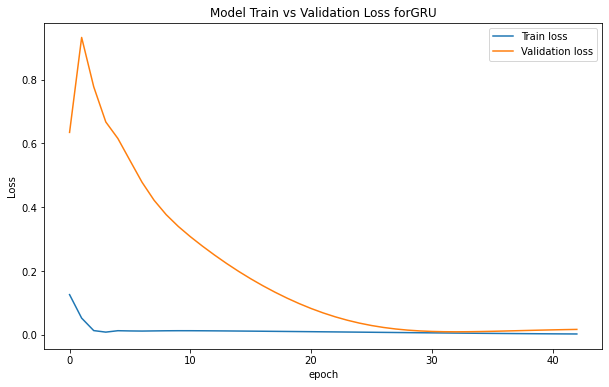

In [67]:
plot_loss(history_gru4, 'GRU')


[[36385.816 38347.062]
 [36889.117 38053.504]
 [37641.625 35787.246]
 [37140.734 35615.87 ]
 [36194.676 35698.297]
 [35443.773 31676.693]
 [34371.22  32505.66 ]
 [33166.406 33723.027]
 [32364.3   34662.438]
 [32053.074 31637.78 ]
 [31964.963 32186.275]
 [32147.477 34649.645]
 [32325.936 34434.336]
 [32864.918 35867.777]
 [32958.793 35040.836]]
Test RMSE: 1979.137


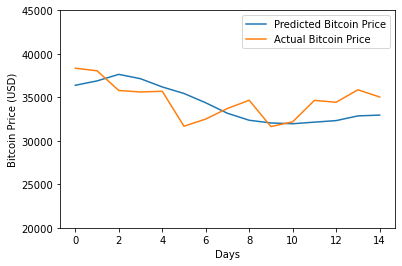

,Actual,Predicted
0,38347.062500,36385.816406
1,38053.503906,36889.117188
2,35787.246094,37641.625000
3,35615.871094,37140.734375
4,35698.296875,36194.675781
5,31676.693359,35443.773438
6,32505.660156,34371.218750
7,33723.027344,33166.406250
8,34662.437500,32364.300781
9,31637.779297,32053.074219


In [68]:
# make a prediction
yhat = model_gru4.predict(test_X)

test_X_Re = test_X.reshape((test_X.shape[0], backwarddays*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat[:,:1], test_X_Re[:, -n_features+1:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)

# invert scaling for actual

inv_y = concatenate((test_y[:,:1], test_X_Re[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

# calculate RMSE
print(concatenate((inv_yhat[:,:1], inv_y[:,:1]), axis=1))
rmse = sqrt(mean_squared_error(inv_yhat[:,0], inv_y[:,0]))
print('Test RMSE: %.3f' % rmse)
pyplot.plot(inv_yhat[:,0], label='Predicted Bitcoin Price')
pyplot.plot(inv_y[:,0], label='Actual Bitcoin Price')
pyplot.xlabel("Days")
pyplot.ylabel("Bitcoin Price (USD)")
x1,x2,y1,y2 = pyplot.axis()  
pyplot.axis((x1,x2,20000,45000))
pyplot.legend()
pyplot.show()
bitcoin_price = pd.DataFrame(columns = {'Predicted', 'Actual'})
bitcoin_price['Predicted'] = inv_yhat[:,0]
bitcoin_price['Actual'] = inv_y[:,0]
bitcoin_price